In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, Descent, params, throttle, Dropout, @epochs, testmode!

using Plots

using Base.Iterators: repeated

using DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter

loaded


# DATA IMPORT

In [2]:
X_columns = h5read("./data/DataSet.hdf5", "X_columns")

X_entropy = h5read("./data/DataSet.hdf5", "X_entropy")
X_entropy_sc = h5read("./data/DataSet.hdf5", "X_entropy_sc")

X_tv = h5read("./data/DataSet.hdf5", "X_tv")
X_tv_sc = h5read("./data/DataSet.hdf5", "X_tv_sc")
y_tv = h5read("./data/DataSet.hdf5", "y_tv")

X_train = h5read("./data/DataSet.hdf5", "X_train")
X_train_sc = h5read("./data/DataSet.hdf5", "X_train_sc")
y_train = h5read("./data/DataSet.hdf5", "y_train")

X_valid = h5read("./data/DataSet.hdf5", "X_valid")
X_valid_sc = h5read("./data/DataSet.hdf5", "X_valid_sc")
y_valid = h5read("./data/DataSet.hdf5", "y_valid")

X_test = h5read("./data/DataSet.hdf5", "X_test")
X_test_sc = h5read("./data/DataSet.hdf5", "X_test_sc")
y_test = h5read("./data/DataSet.hdf5", "y_test")

X_scaler_mean = h5read("./data/DataSet.hdf5", "X_scaler_mean")
X_scaler_var = h5read("./data/DataSet.hdf5", "X_scaler_var")
println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_tv))

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg", "ScT"]

Shape of X train and valid is
(13, 1049)


In [3]:
function prepare_datas(X_,y_)
    
    y = reshape(y_[:],1,length(y_))
    
    
    ap = reshape(X_[8,:],1,size(X_,2))
    b = reshape(X_[9,:],1,size(X_,2))
    T = reshape(X_[10,:],1,size(X_,2))
    #be = reshape(X_[11,:],1,size(X_,2))
    sc = reshape(X_[11,:],1,size(X_,2))
    tg = reshape(X_[12,:],1,size(X_,2))
    
    x = X_[1:4,:]
    
    return x, y, T, ap, b, sc, tg
end

function gkfolds(X_, y_, idx_label; k = 5)

    dd = kfolds(shuffleobs(unique(X_[idx_label,:])), k = k);
    
    out = []
    
    for j = 1:k
        train_lab, vald_lab = dd[j]
        train_idx = Int64[]
        valid_idx = Int64[]

        for i = 1:size(X_,2)
            if findall(X_[idx_label,i] .== train_lab) != []
                push!(train_idx, i)
            else
                push!(valid_idx, i)
            end
        end
        
        push!(out,((X_[:,train_idx],y_[train_idx]),(X_[:,valid_idx],y_[valid_idx])))
        
    end
    
    return out
end


gkfolds (generic function with 1 method)

In [4]:
nb_folds = 5
folds = gkfolds(X_train_sc,y_train,12,k=nb_folds);

folds_entropy = gkfolds(X_entropy_sc,X_entropy_sc[11,:],12,k=nb_folds);

# Model

In [5]:
# The model

#
# Cps
#

at_gfu(x) = 3.0.*x[1,:] .+ 5.0.*x[2,:] + 3.0.*x[3,:] + 3.0.*x[4,:]# + 2*MgO + 2*MgO
aCpl(x) = 81.37.*x[1,:] .+ 27.21.*x[2,:] .+ 100.6.*x[3,:]  .+ 50.13.*x[4,:] .+ x[1,:].*(x[4,:].*x[4,:]).*151.7

ap(x) = reshape(aCpl(x) - 3.0.*8.314.*at_gfu(x),1,size(x,2))
b(x) = reshape(0.0943.*x[2,:] + 0.01578.*x[4,:],1,size(x,2)) #bCpl

#
# With two subnetworks for Be and Sc
#
#m1 = Chain(
#    Dense(7, 100, relu),
#    #Dropout(0.2),
#    Dense(100, 1)) # |> gpu

m1 = Chain(
    Dense(4, 10, relu),
    Dense(10, 2)) # |> gpu

# Other stuffs

Ae = param([-2.11])

B(x) = reshape(exp.(m1(x[1:4,:])[1,:])*10000.0,1,size(x,2))
C(x) = reshape(exp.(m1(x[1:4,:])[2,:])*10.0,1,size(x,2))

#tg(x) = 1.0./(12.0.-Ae).*BeSc(x)

model(x,T) = Ae .+B(x)./(T - C(x))

mse(yp, y) = sqrt(sum((yp .- y).^2)./size(y, 2))


# loss functions

loss_n(x, T, y_target) = mse(model(x, T), y_target)

loss_n (generic function with 1 method)

# Training

# VISCOSITY

In [6]:
opt = ADAM(0.001)
fold_select = 1
nb_epochs = 5000

early_stop = 50

###########

record_loss_n_train = Float64[]
record_loss_n_valid = Float64[]

record_folds_train = Float64[]
record_folds_valid = Float64[]

count_es = 0
count_es_record = zeros(nb_epochs)

p = ProgressMeter.Progress(nb_epochs, 1)   # minimum update interval: 1 second

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

for epoch_idx in 1:nb_epochs
            
    evalcb = () -> (push!(record_loss_n_train,loss_n(x_train_, T_train_ , y_train_).data),
    push!(record_loss_n_valid,loss_n(x_valid_, T_valid_ , y_valid_).data)) #@show(loss_be(x_train, be_train),loss_be(x_valid, be_valid))

    dataset = [(x_train_, T_train_, y_train_)]

    Flux.train!(loss_n, params(Ae,m1), dataset, opt, cb = throttle(evalcb, 1))
    
    ProgressMeter.update!(p, epoch_idx)
    
    # Early stopping criterion
    if epoch_idx > 1
        if record_loss_n_valid[epoch_idx] > record_loss_n_valid[epoch_idx-1]
            count_es += 1
        end
    end
    count_es_record[epoch_idx] = count_es
    if count_es > early_stop
        #break;
    end
    
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:19m


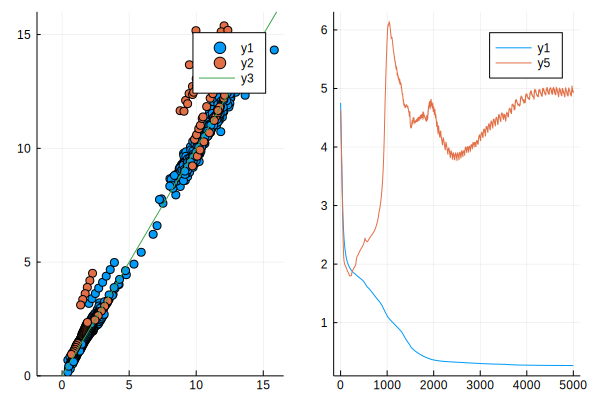

In [7]:
testmode!(m1)
#testmode!(m2)

p1 = scatter(y_train_[:],
    model(x_train_,T_train_).data[:],)
scatter!(y_valid_[:],
    model(x_valid_,T_valid_).data[:],)
plot!([0.,16.],[0.,16.],ylim=(0,16))


#p1 = scatter(y_tv[:],model(x_tv_,T_tv_,ap_tv_, b_tv_).data[:])

p2 = plot(collect(1:1:length(record_loss_n_train)),record_loss_n_train)

plot(p1,p2,layout=2)

plot!(collect(1:1:length(record_loss_n_valid)),record_loss_n_valid,subplot=2)
# plot(record_loss_n_train,label="valid")
# plot(record_loss_n_valid,label="train")
# yscale("log")
# legend()
#println(loss(x_train,T_train, ap_train, b_train, y_train))

In [8]:
print(minimum(record_loss_n_train))
print("\n")
print(minimum(record_loss_n_valid))

0.2672305590175094
1.7972229885449913

# TEST

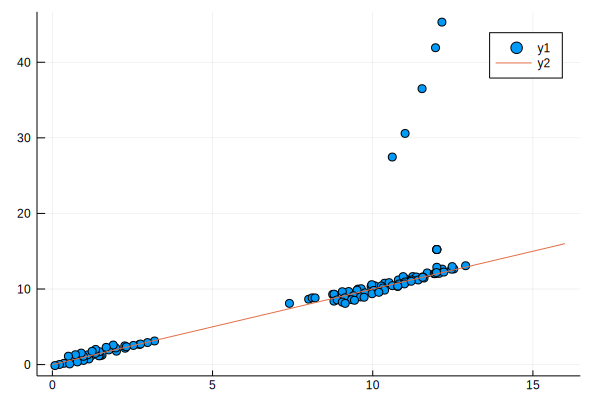

In [10]:
x_test, y_test, T_test, ap_test, b_test, sc_test, tg_test = prepare_datas(X_test_sc,y_test)

scatter(vec(y_test),model(x_test,T_test).data[:])
plot!([0.,16.],[0.,16.])

#println(mse(y_test,model(x_test,T_test,ap_test,b_test).data[:]))

In [50]:
X_visu_NKS

13×25 Array{Float64,2}:
    0.486652     0.486652      0.486652   …     0.486652      0.486652 
   -1.04706     -1.04706      -1.04706         -1.04706      -1.04706  
    0.918322     0.821566      0.724809        -1.30708      -1.40383  
   -0.521182    -0.389545     -0.257908         2.50647       2.63811  
   -0.66656     -0.66656      -0.66656          0.320926      0.320926 
    0.551949     0.484245      0.416541   …    -1.00523      -1.07294  
    1.22323      1.22323       1.22323          1.22323       1.22323  
   11.3515      10.8582       10.3876           5.7621        5.79214  
    0.0          0.0001578     0.0003156        0.0036294     0.0037872
 1000.0       1000.0        1000.0           1000.0        1000.0      
  NaN          NaN           NaN          …   NaN           NaN        
  NaN          NaN           NaN              NaN           NaN        
  NaN          NaN           NaN              NaN           NaN        

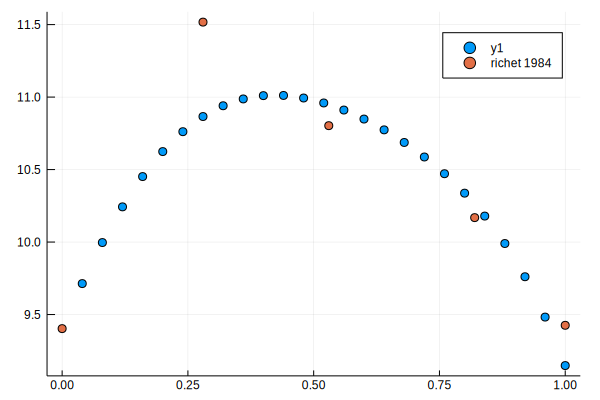

In [104]:
X_visu_NKS = h5read("./data/DataSet_visu.hdf5", "X_arti_NKS")
x_visu_xaxis = copy(X_visu_NKS)

for i = 1:7
    x_visu_xaxis[i,:] = X_visu_NKS[i,:].*sqrt.(X_scaler_var[i]) .+ X_scaler_mean[i]
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter(x_visu_xaxis[3,:]./(x_visu_xaxis[3,:].+x_visu_xaxis[4,:]),ScTg(X_visu_NKS).data'[:])
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

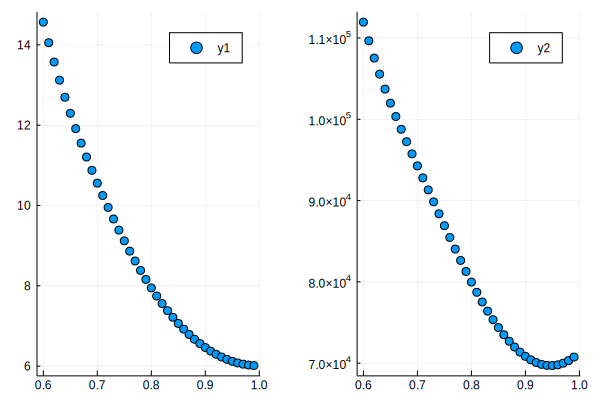

In [98]:
X_visu_NS = h5read("./data/DataSet_visu.hdf5", "X_arti_NS")
xns_visu_xaxis = copy(X_visu_NS)

for i = 1:7
    xns_visu_xaxis[i,:] = X_visu_NS[i,:].*sqrt.(X_scaler_var[i]) .+ X_scaler_mean[i]
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter([xns_visu_xaxis[1,:],xns_visu_xaxis[1,:]],
    [ScTg(X_visu_NS).data'[:],Be(X_visu_NS).data'[:]],
layout=2)
#scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

In [299]:
predictions_train = predict(x)

Tracked 620×620 Array{Float64,2}:
 -4.49918  -4.49918  -4.49918  -4.49918  …  -4.4996   -4.4996   -4.4996 
 -4.49916  -4.49916  -4.49916  -4.49916     -4.49959  -4.49959  -4.49959
 -4.49912  -4.49912  -4.49912  -4.49912     -4.49957  -4.49957  -4.49957
 -4.49909  -4.49909  -4.49909  -4.49909     -4.49955  -4.49955  -4.49955
 -4.49904  -4.49904  -4.49904  -4.49904     -4.49953  -4.49953  -4.49953
 -4.49901  -4.49901  -4.49901  -4.49901  …  -4.49951  -4.49951  -4.49951
 -4.49896  -4.49896  -4.49896  -4.49896     -4.49949  -4.49949  -4.49949
 -4.49892  -4.49892  -4.49892  -4.49892     -4.49947  -4.49947  -4.49947
 -4.49885  -4.49885  -4.49885  -4.49885     -4.49943  -4.49943  -4.49943
 -4.49882  -4.49882  -4.49882  -4.49882     -4.49942  -4.49942  -4.49942
 -4.49871  -4.49871  -4.49871  -4.49871  …  -4.49936  -4.49936  -4.49936
 -4.49866  -4.49866  -4.49866  -4.49866     -4.49934  -4.49934  -4.49934
 -4.49861  -4.49861  -4.49861  -4.49861     -4.49931  -4.49931  -4.49931
  ⋮              

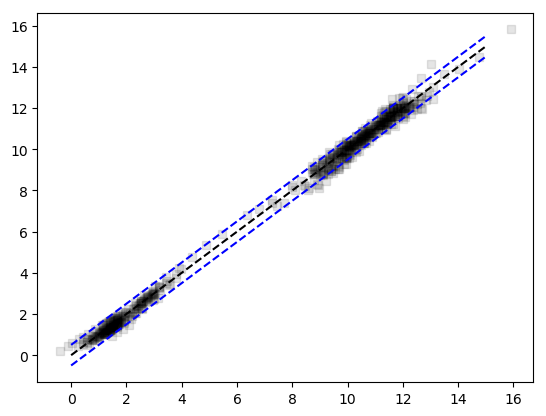

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f041fbb1cc0>

In [197]:
plot(predictions_train.data[:],y.parent[:],"ks",alpha=0.1)
plot([0,15],[0,15],"k--")
plot([0,15.0],[0,15.].-0.5,"b--")
plot([0,15.],[0,15.].+0.5,"b--")

In [195]:
plot([0,12]-0.5,[0,12]-0.5,"k--")

MethodError: MethodError: no method matching -(::Array{Int64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:397
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:97
  ...

In [188]:
predictions_train.data[:]

620-element Array{Float64,1}:
  2.3032444067117757
  2.623692405633248 
  3.027915455938361 
  3.4222450165673743
  3.8926449255113944
  4.370103390672524 
  4.8876503648035   
  5.469334558026265 
  6.356743420865268 
  6.78613859050153  
  8.327278676684431 
  9.051372238986819 
  9.944407111041677 
  ⋮                 
  1.4055438658956634
  1.4422492073169009
  1.479413679478652 
  1.5170459511904548
  1.5551549108774632
  1.5937496735794525
  1.6328395882192055
  1.6724342451524592
  9.332781439644776 
 10.09932163190039  
 10.621319672155154 
 11.212695098263817 

In [191]:
m1(x)

Tracked 1×620 Array{Float32,2}:
 15123.9  15123.9  15123.9  15123.9  …  8035.39  8035.39  8035.39  8035.39